In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
%matplotlib inline

In [19]:
aqi = pd.read_csv("/content/City_Air_Quality.csv", encoding="ISO-8859-1", parse_dates=['sampling_date'])


In [20]:
sns.set(style="ticks", rc = {'figure.figsize':(20,15)})
# Supressing update warnings
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Dropping unnecessary columns
aqi.drop(['stn_code', 'agency', 'sampling_date', 'location_monitoring_station'], axis=1, inplace=True)

# Dropping rows where no date is available
aqi = aqi.dropna(subset=['date'])

# Cleaning up name changes in the 'state' column
aqi.state = aqi.state.replace({'Uttaranchal': 'Uttarakhand'})

# Fixing state name for rows where 'location' is 'Jamshedpur'
aqi.loc[aqi.location == 'Jamshedpur', 'state'] = 'Jharkhand'
types = {
"Residential": "R",
"Residential and others": "RO",
"Residential, Rural and other Areas": "RRO",
"Industrial Area": "I",
"Industrial Areas": "I",
"Industrial": "I",
"Sensitive Area": "S",
"Sensitive Areas": "S",
"Sensitive": "S",
np.nan: "RRO"
}
aqi.type = aqi.type.replace(types)


In [24]:
VALUE_COLS = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']


In [25]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
aqi[VALUE_COLS] = imputer.fit_transform(aqi[VALUE_COLS])

In [35]:
def plot_for_state(state_name):
    # Create subplots
    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(state_name, size=20)

    # Filter the data for the selected state
    state_data = aqi[aqi.state == state_name]

    # Ensure the 'date' column is in datetime format
    state_data['date'] = pd.to_datetime(state_data['date'], errors='coerce')

    # Drop rows where the date conversion failed (optional)
    state_data.dropna(subset=['date'], inplace=True)

    # Set 'date' as the index
    state_data.set_index('date', inplace=True)

    # Resample the data to a yearly frequency and calculate the average for each year
    state_data = state_data[VALUE_COLS].resample('Y').mean()

    # Plot SO2 levels
    state_data.so2.plot(legend=True, ax=ax[0][0], title="SO2 Levels")
    ax[0][0].set_ylabel("SO2 (μg/m3)")
    ax[0][0].set_xlabel("Year")

    # Plot NO2 levels
    state_data.no2.plot(legend=True, ax=ax[0][1], title="NO2 Levels")
    ax[0][1].set_ylabel("NO2 (μg/m3)")
    ax[0][1].set_xlabel("Year")

    # Plot RSPM (PM10) levels
    state_data.rspm.plot(legend=True, ax=ax[1][0], title="RSPM (PM10) Levels")
    ax[1][0].set_ylabel("RSPM (PM10 μg/m3)")
    ax[1][0].set_xlabel("Year")

    # Plot SPM levels
    state_data.spm.plot(legend=True, ax=ax[1][1], title="SPM (PM10) Levels")
    ax[1][1].set_ylabel("SPM (PM10 μg/m3)")
    ax[1][1].set_xlabel("Year")

    # Display the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


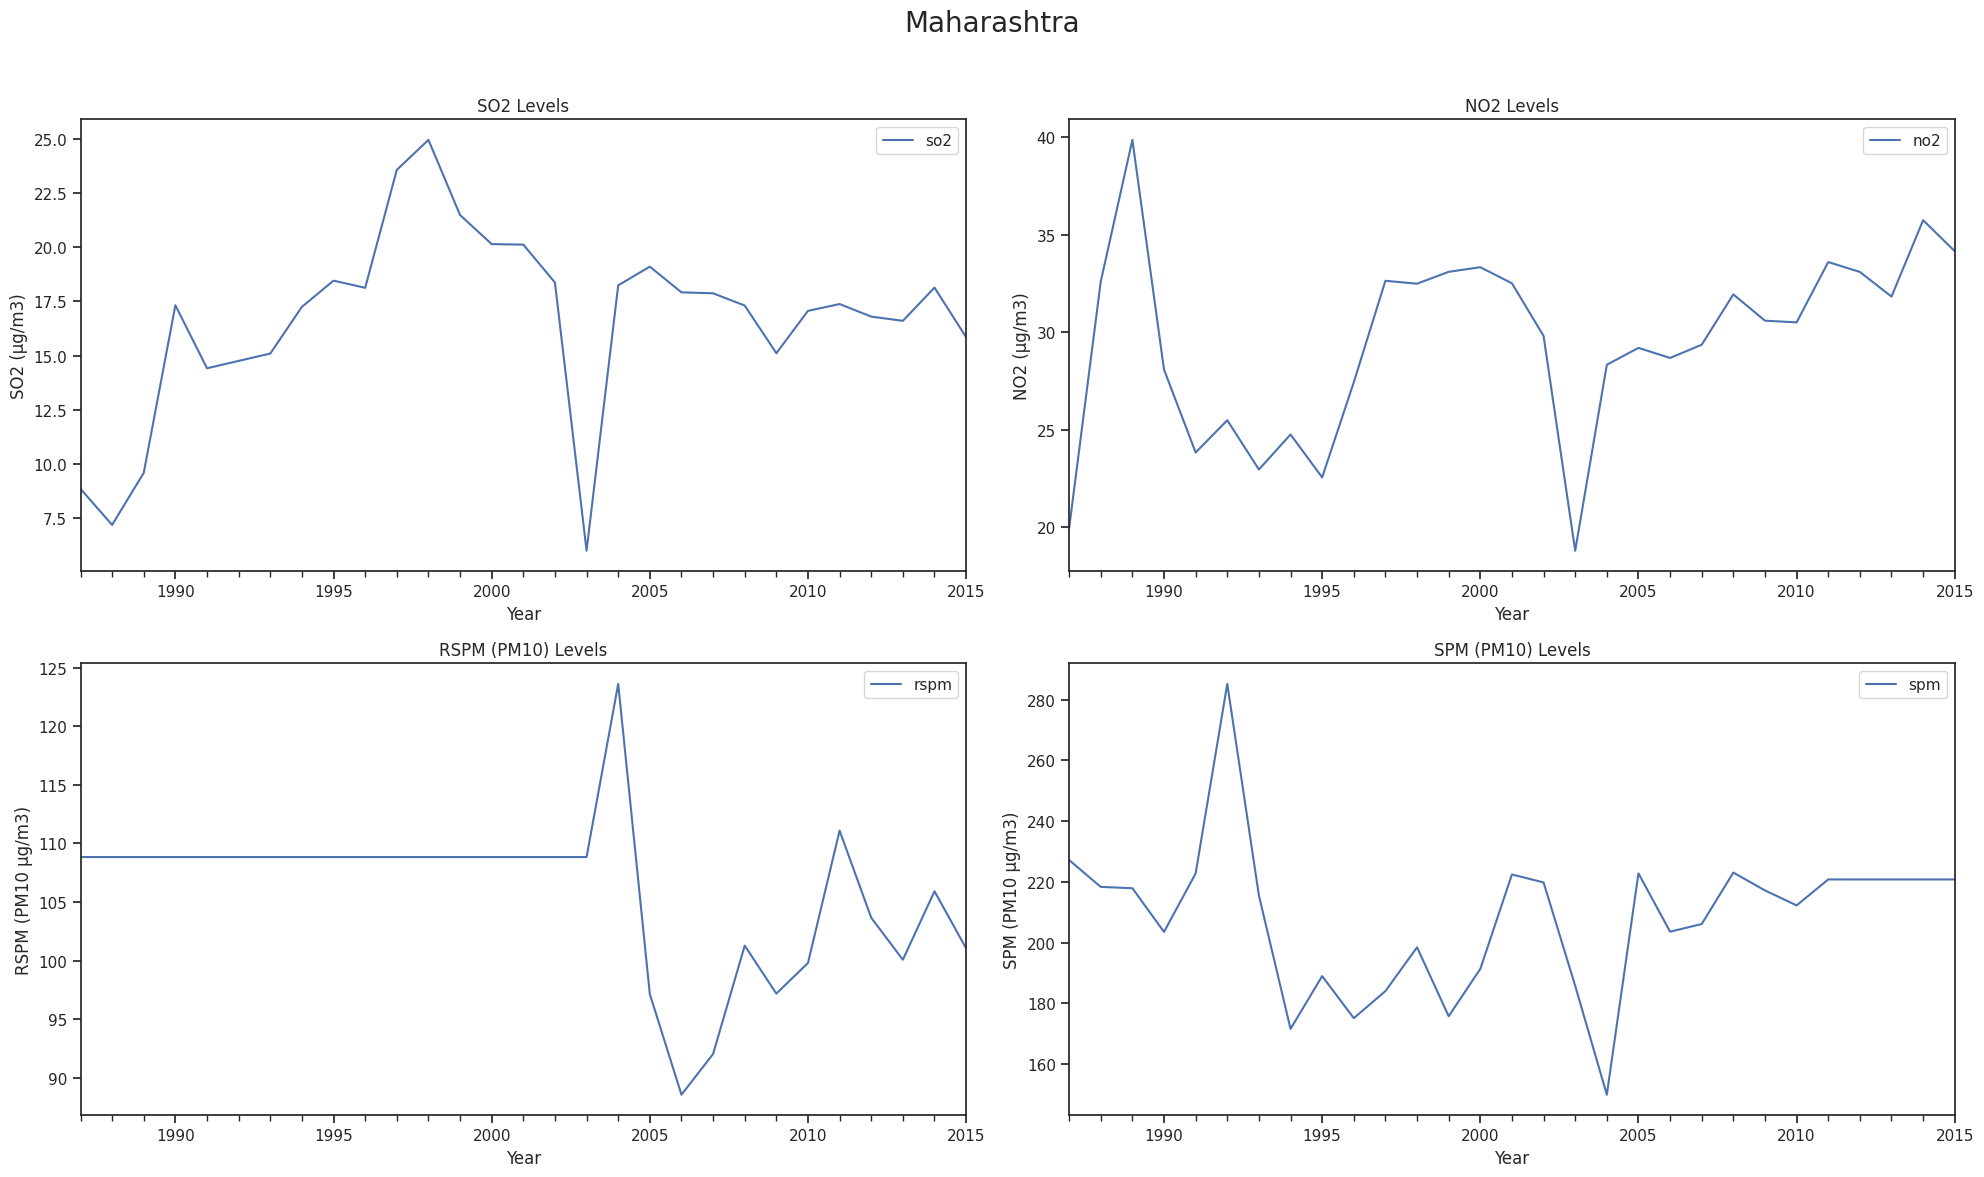

In [37]:
plot_for_state("Maharashtra")

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def top_and_bottom_10_states(indicator="so2"):
    # Create subplots for top and bottom 10 states
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))

    # Group the data by 'state' and calculate the median of the chosen indicator
    ind = aqi[[indicator, 'state']].groupby('state', as_index=False).median()

    # Sort the data by the chosen indicator
    ind = ind.sort_values(by=indicator, ascending=False)

    # Plot the top 10 states
    top10 = sns.barplot(x='state', y=indicator, data=ind[:10], ax=ax[0])
    top10.set_title(f"Top 10 states by {indicator.upper()} (1991-2016)")
    top10.set_ylabel(f"{indicator.upper()} (μg/m3)")
    top10.set_xlabel("State")

    # Plot the bottom 10 states
    bottom10 = sns.barplot(x='state', y=indicator, data=ind[-10:], ax=ax[1])
    bottom10.set_title(f"Bottom 10 states by {indicator.upper()} (1991-2016)")
    bottom10.set_ylabel(f"{indicator.upper()} (μg/m3)")
    bottom10.set_xlabel("State")

    # Display the plots
    plt.tight_layout()
    plt.show()


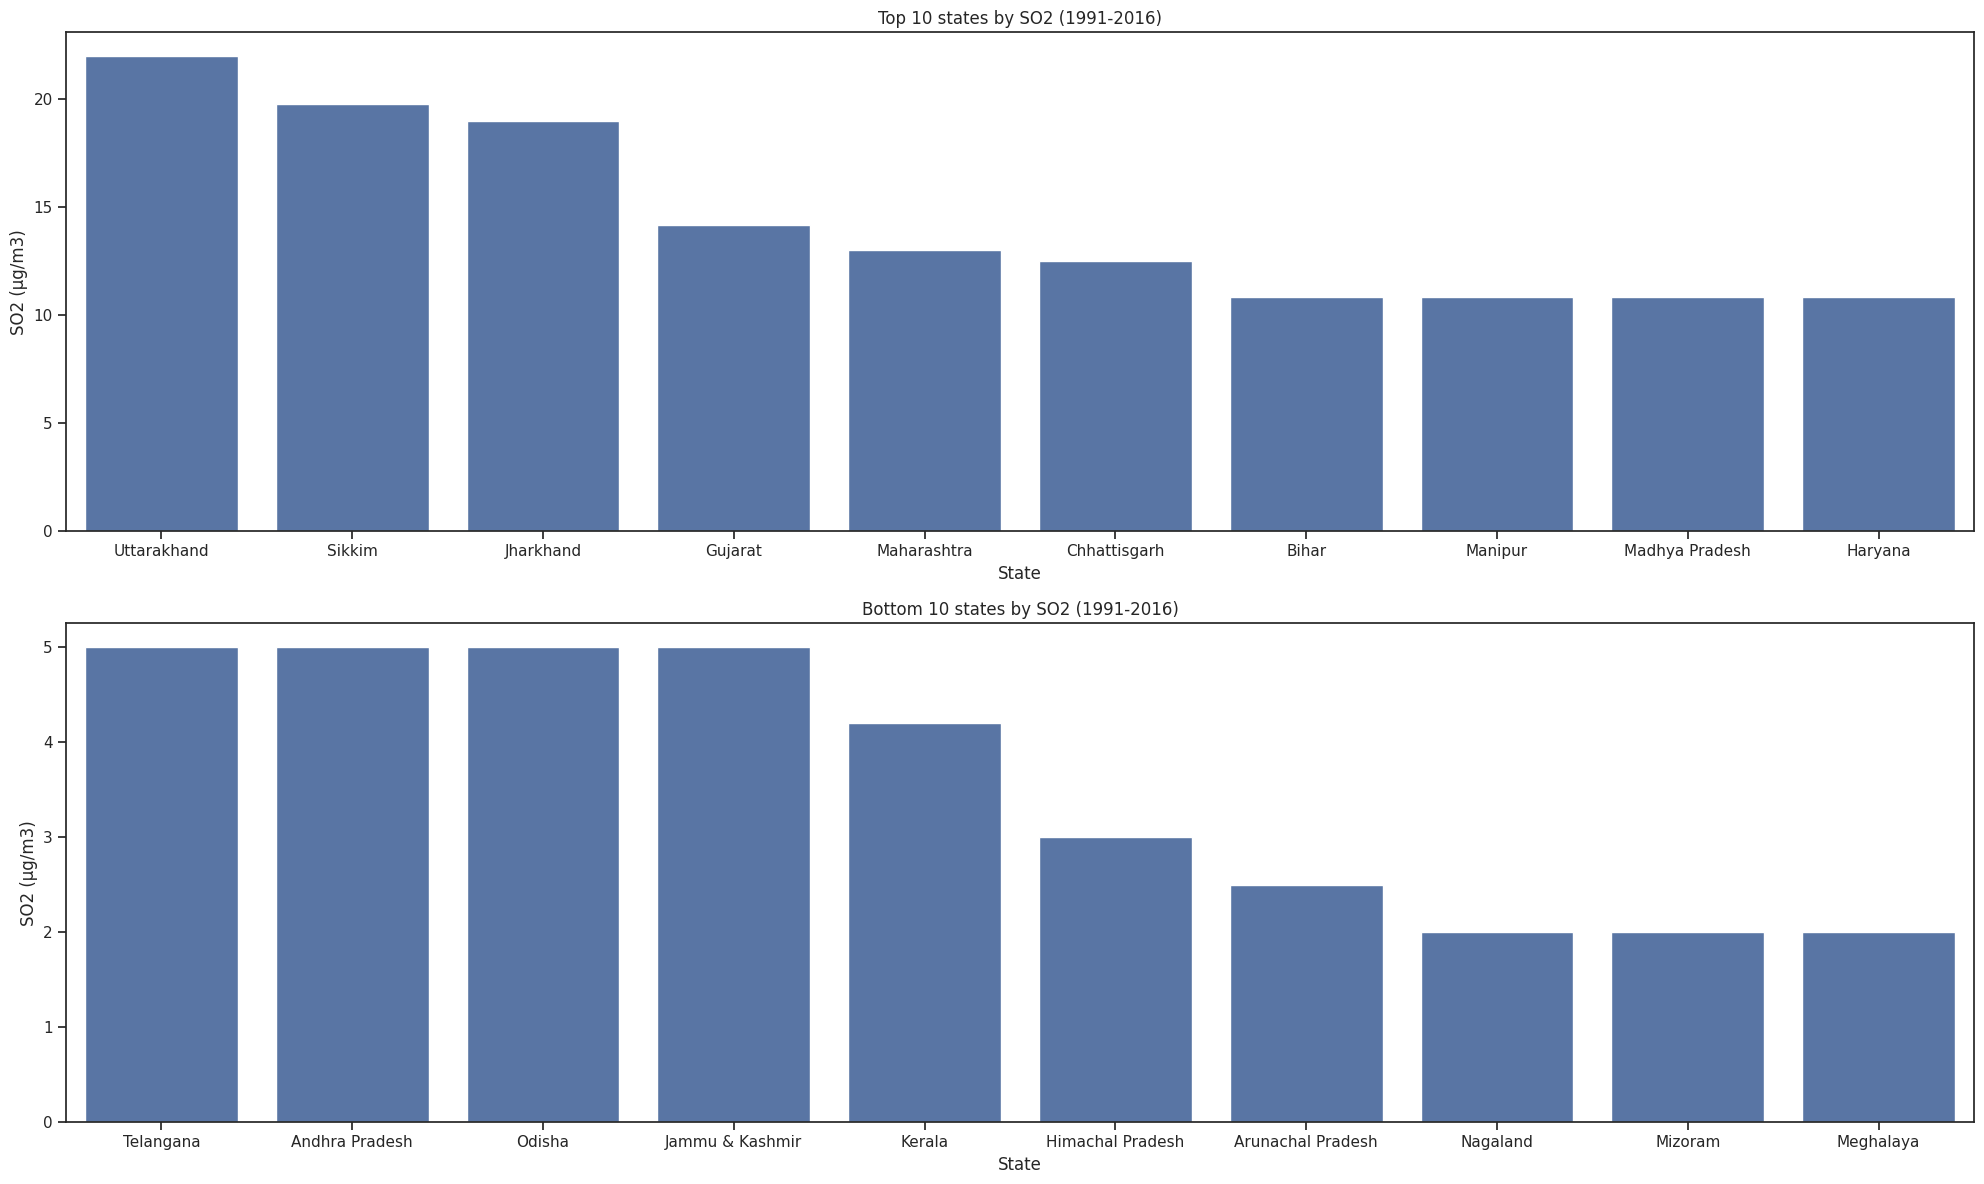

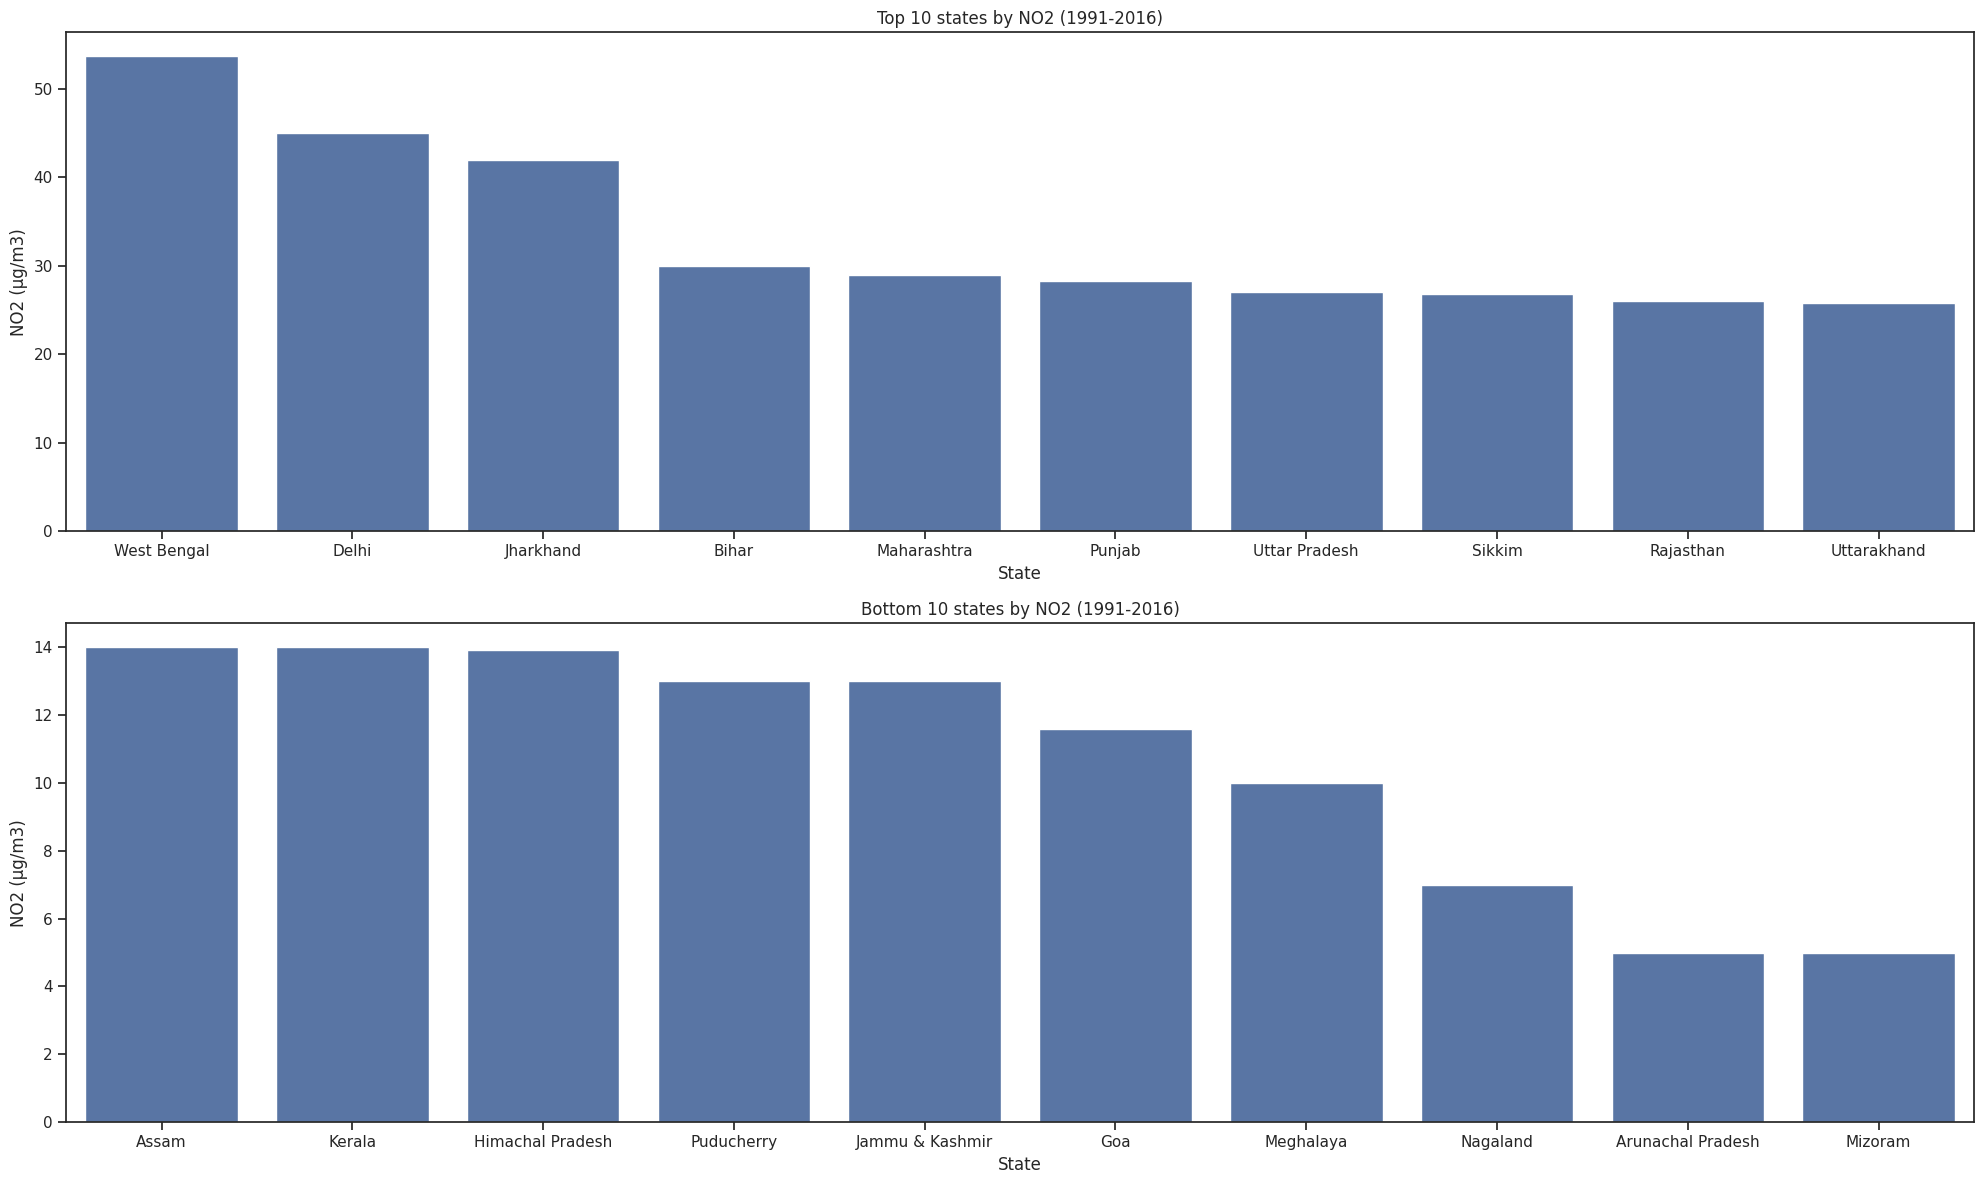

In [39]:
top_and_bottom_10_states("so2")
top_and_bottom_10_states("no2")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def yearly_trend(state="", indicator="so2"):
    plt.figure(figsize=(20, 12))

    # Ensure the 'date' column is in datetime format and extract the year
    aqi['year'] = pd.to_datetime(aqi['date'], errors='coerce').dt.year

    if state == "":
        # Group by year to calculate the mean for each indicator across all states
        year_wise = aqi[[indicator, 'year']].groupby('year', as_index=False).mean()
        # Create a point plot for the yearly trend
        trend = sns.pointplot(x='year', y=indicator, data=year_wise)
        trend.set_title('Yearly trend of {}'.format(indicator.upper()))
    else:
        # Group by state and year to calculate the mean for each indicator
        year_wise = aqi[[indicator, 'year', 'state']].groupby(['state', 'year'], as_index=False).mean()
        # Filter for the specified state
        state_data = year_wise[year_wise['state'] == state]
        # Create a point plot for the yearly trend for the specified state
        trend = sns.pointplot(x='year', y=indicator, data=state_data)
        trend.set_title('Yearly trend of {} for {}'.format(indicator.upper(), state))

    # Set labels
    trend.set_ylabel('{} (μg/m3)'.format(indicator.upper()))
    trend.set_xlabel('Year')

    # Display the plot
    plt.tight_layout()
    plt.show()


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20, 10))

    # Group by state and calculate the maximum value of the specified indicator
    ind = aqi[[indicator, 'location', 'state', 'date']].groupby('state', as_index=False).max()

    # Create a bar plot for the highest levels recorded by state
    highest = sns.barplot(x='state', y=indicator, data=ind)

    # Set title and labels
    highest.set_title("Highest ever {} levels recorded by state".format(indicator.upper()))
    highest.set_ylabel("{} (μg/m3)".format(indicator.upper()))
    highest.set_xlabel("State")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Display the plot
    plt.tight_layout()
    plt.show()


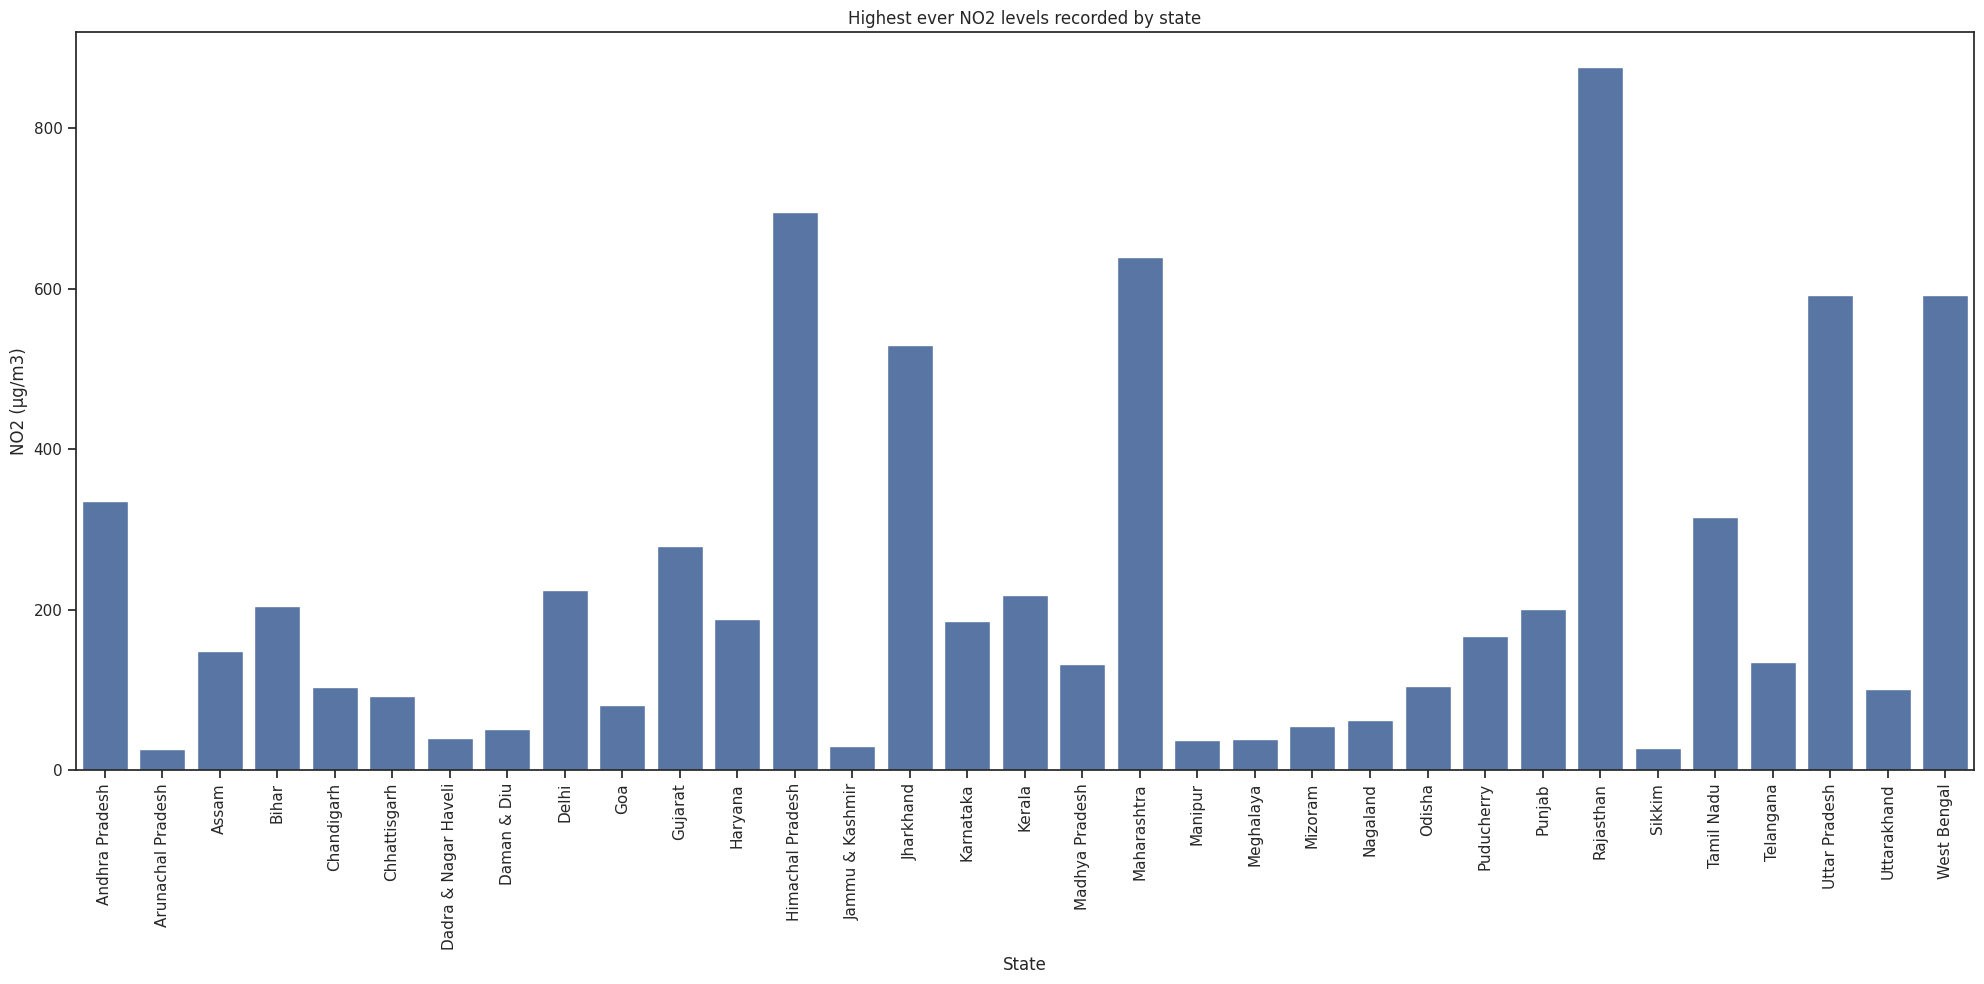

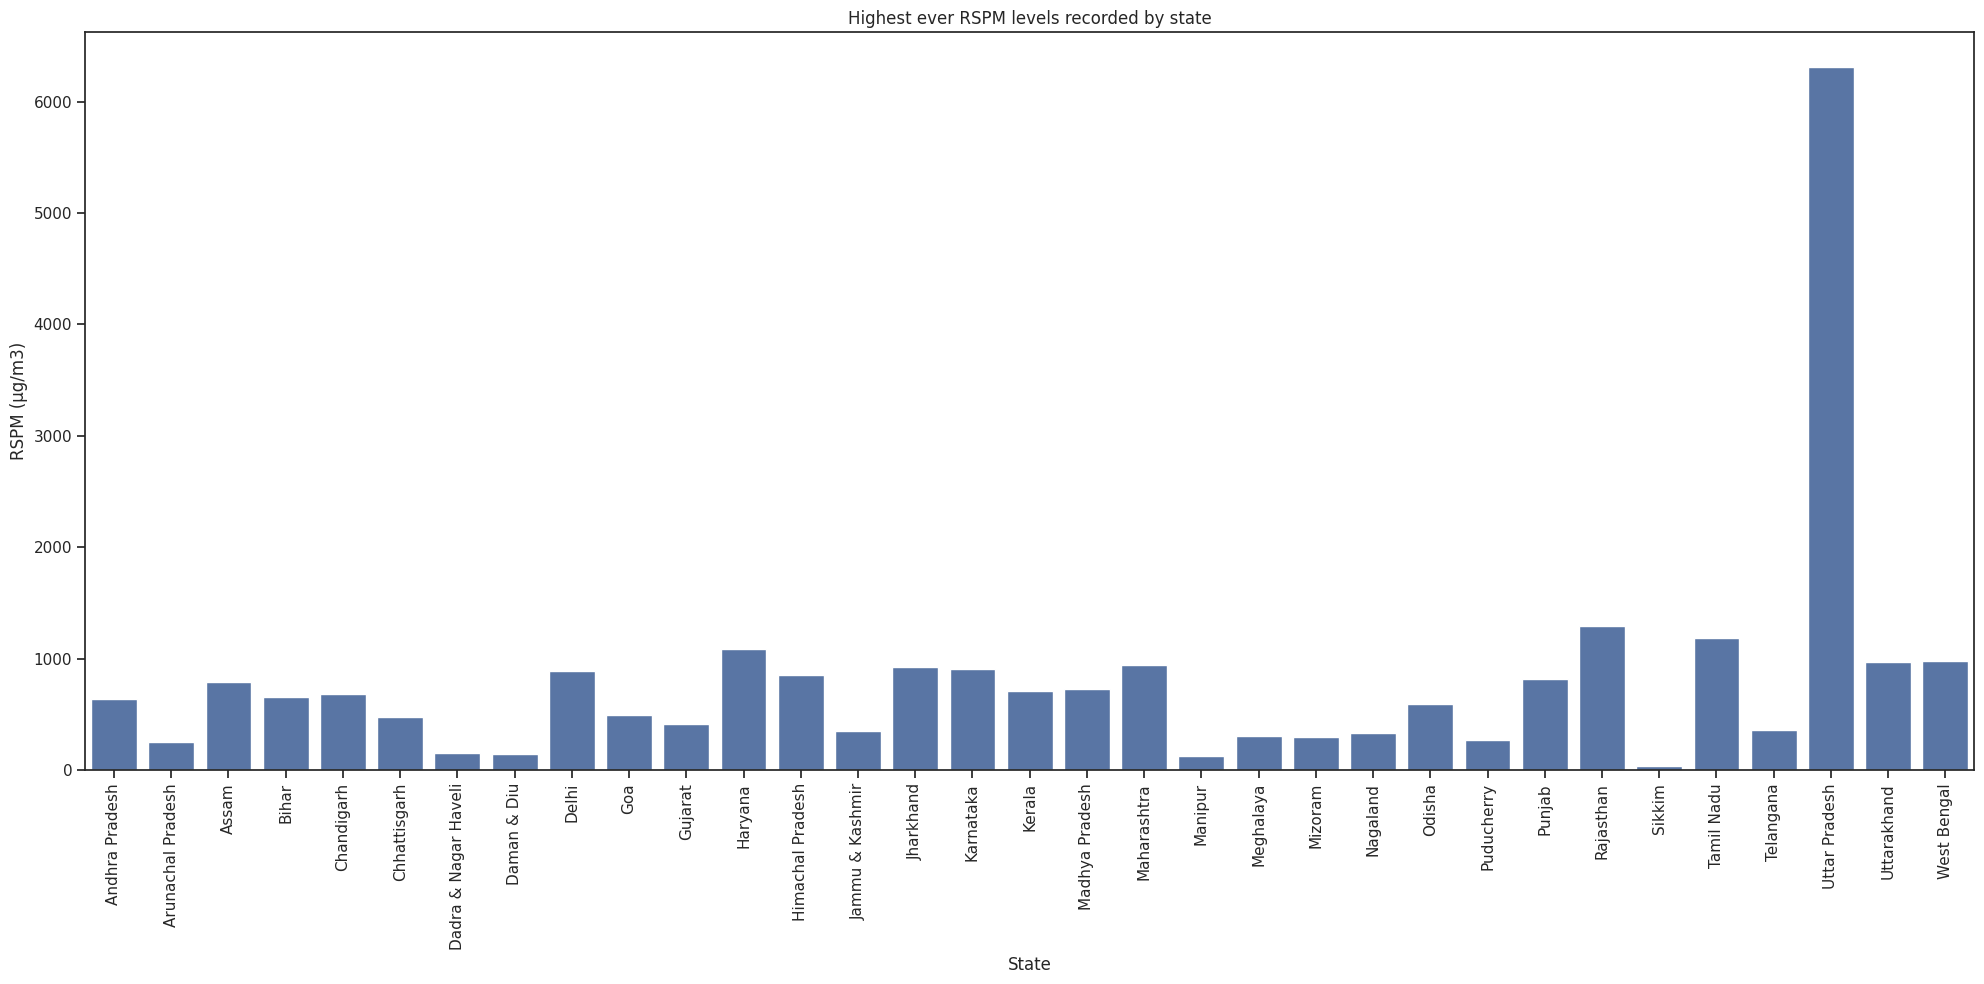

In [41]:
highest_levels_recorded("no2")
highest_levels_recorded("rspm")

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def location_avgs(state, indicator="so2"):
    # Grouping the data by state and location, calculating the mean for the specified indicator
    locs = aqi[VALUE_COLS + ['state', 'location']].groupby(['state', 'location'], as_index=False).mean()

    # Filter the data for the specified state
    state_avgs = locs[locs['state'] == state].reset_index()

    # Create a bar plot for the average indicator values for each location within the state
    plt.figure(figsize=(20, 10))
    sns.barplot(x='location', y=indicator, data=state_avgs)

    # Set the title and labels for the plot
    plt.title("Location-wise average for {} in {}".format(indicator.upper(), state))
    plt.ylabel("{} (μg/m3)".format(indicator.upper()))
    plt.xlabel("Location")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Display the plot
    plt.tight_layout()
    plt.show()


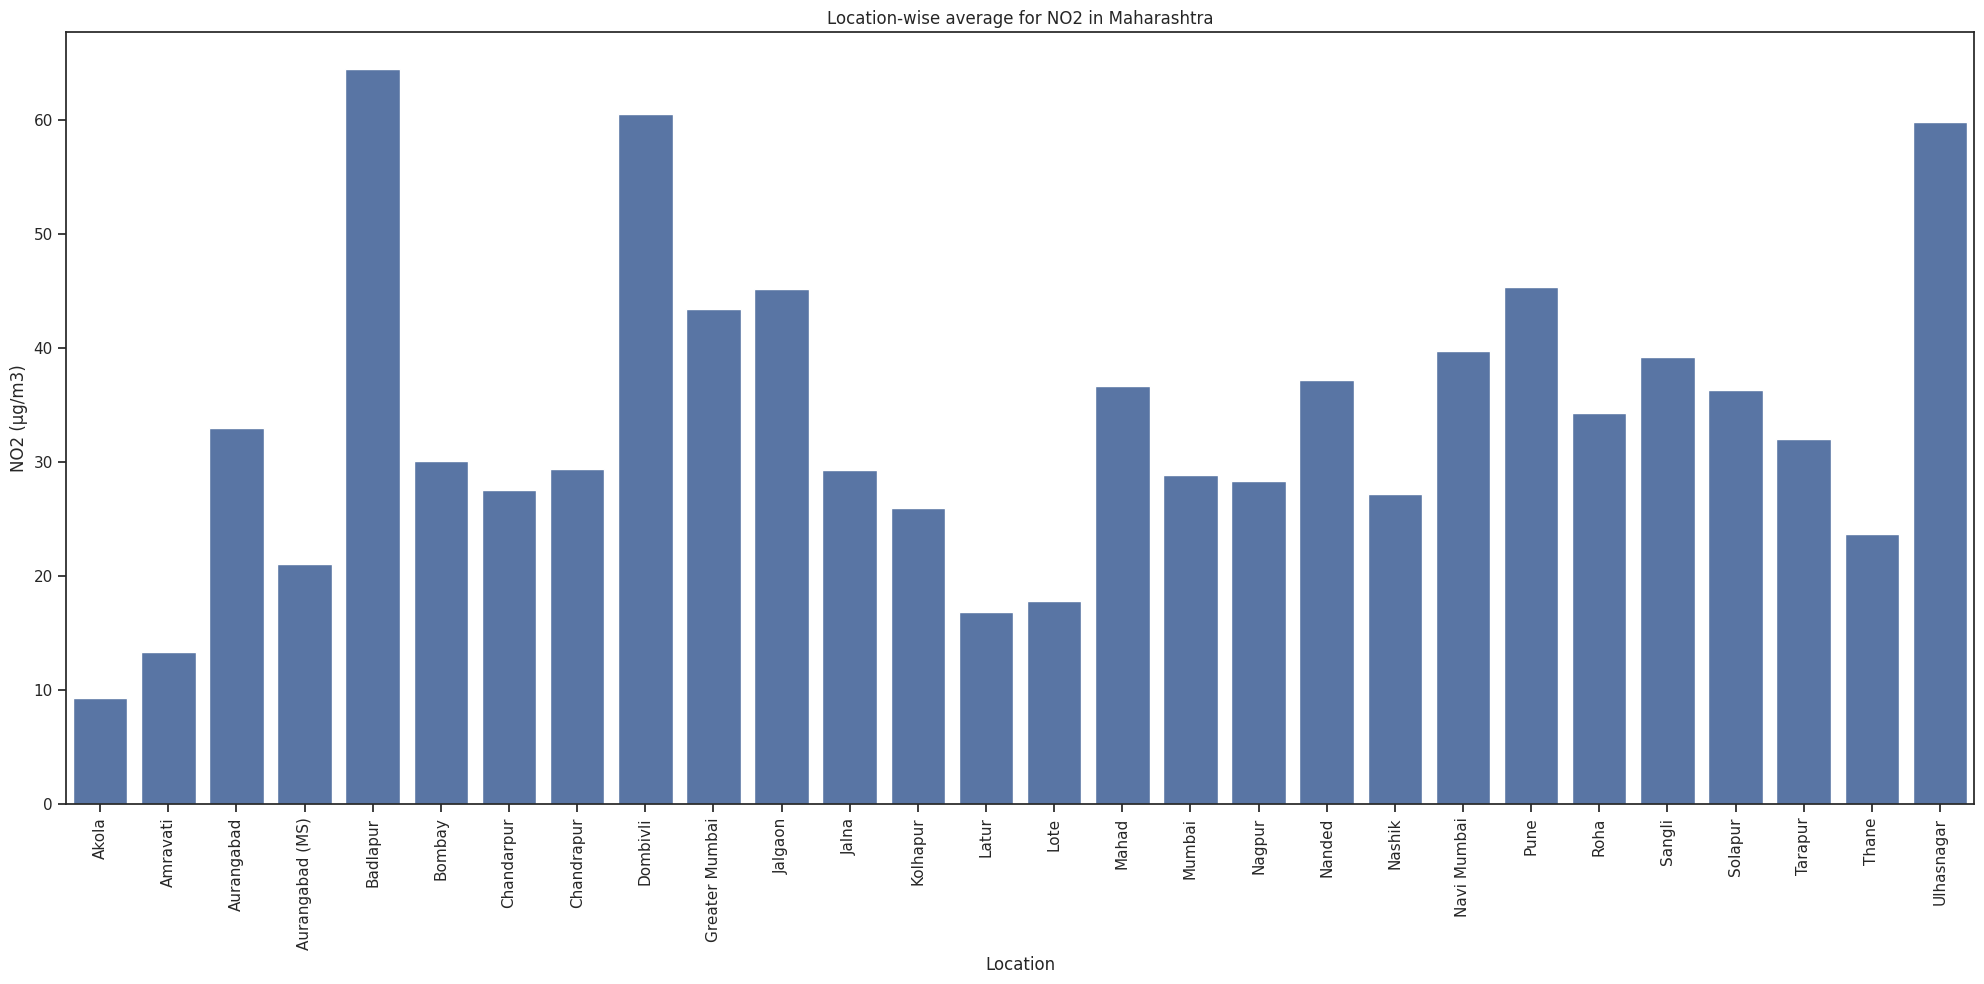

In [47]:
location_avgs("Maharashtra", "no2")